Select target genes and transcripts using sequencing data.

In [1]:
# Download the single-cell sequencing data
!mkdir temporary_data
!mkdir temporary_data/example_select_target_genes
!wget https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/scell/10x_v3/mouse/processed/analysis/10X_cells_v3_AIBS/matrix.mtx.gz -O temporary_data/example_select_target_genes/matrix.mtx.gz
!gzip -d temporary_data/example_select_target_genes/matrix.mtx.gz -f
!wget https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/scell/10x_v3/mouse/processed/analysis/10X_cells_v3_AIBS/features.tsv.gz -O temporary_data/example_select_target_genes/features.tsv.gz
!gzip -d temporary_data/example_select_target_genes/features.tsv.gz -f
!wget https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/scell/10x_v3/mouse/processed/analysis/10X_cells_v3_AIBS/cluster.membership.csv -O temporary_data/example_select_target_genes/cluster.membership.csv
!wget https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/scell/10x_v3/mouse/processed/analysis/10X_cells_v3_AIBS/cluster.annotation.csv -O temporary_data/example_select_target_genes/cluster.annotation.csv
!wget https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/scell/10x_v3/mouse/processed/analysis/10X_cells_v3_AIBS/barcode.tsv -O temporary_data/example_select_target_genes/barcode.tsv

mkdir: cannot create directory ‘temporary_data’: File exists
--2021-08-11 14:17:16--  https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/scell/10x_v3/mouse/processed/analysis/10X_cells_v3_AIBS/matrix.mtx.gz
Resolving data.nemoarchive.org (data.nemoarchive.org)... 134.192.156.26
Connecting to data.nemoarchive.org (data.nemoarchive.org)|134.192.156.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2966947337 (2.8G) [application/x-gzip]
Saving to: ‘temporary_data/example_select_target_genes/matrix.mtx.gz’

temporary_data/exam 100%[===================>]   2.76G  46.4MB/s    in 59s     

2021-08-11 14:18:15 (48.2 MB/s) - ‘temporary_data/example_select_target_genes/matrix.mtx.gz’ saved [2966947337/2966947337]

--2021-08-11 14:19:13--  https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/scell/10x_v3/mouse/processed/analysis/10X_cells_v3_AIBS/features.tsv.gz
Resolving data.nemoarchive.org (data.nemoarchive.org)... 134.192.156.26
Con

In [1]:
# Input files
mtx_file = 'temporary_data/example_select_target_genes/matrix.mtx'
features_file = 'temporary_data/example_select_target_genes/features.tsv'
barcode_file = 'temporary_data/example_select_target_genes/barcode.tsv'
clusters_file = 'temporary_data/example_select_target_genes/cluster.membership.csv'
clusters_annotation_file = 'temporary_data/example_select_target_genes/cluster.annotation.csv'

# Output files
selected_genes_file = 'temporary_data/example_select_target_genes/target_genes.csv'

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import scanpy as sc
sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=180, dpi_save=300, frameon=False, figsize=(4, 4), fontsize=8, facecolor='white')

In [33]:
# Sorting code from Meng

from random import choice

def permuteOrder(df,axis,switch = 0):
    penaltyMat = np.zeros((df.shape[0],df.shape[1]))
    for i in range(penaltyMat.shape[0]):
        for j in range(penaltyMat.shape[1]):
            penaltyMat[i,j] = np.abs(i-(df.shape[0])/(df.shape[1])*j)**0.5
    if axis == 0:
        sort = df.index.values.copy()
    elif axis == 1:
        sort = df.columns.values.copy()
    dfCopy = df.values.copy()
#     print(dfCopy)
    for i in range(df.shape[int(axis)]):
        penalty = np.full((df.shape[int(axis)]),np.inf)
        for j in range(len(penalty)):
            tempMat = dfCopy.copy()
            if axis == 0:
                tempMat[[i, j],:] = tempMat[[j, i],:]
            elif axis == 1:
                tempMat[:,[i, j]] = tempMat[:,[j, i]]
            penalty[j] = sum(sum(tempMat*penaltyMat))
        idx = np.argmin(penalty)
        if not idx == i:                
            switch += 1
        if axis == 0:
            dfCopy[[i, idx], :] = dfCopy[[idx, i], :];
        elif axis == 1:
            dfCopy[:,[i, idx]] = dfCopy[:,[idx, i]];
        else:
            print('bad axis {}'.format(axis))
        sort[[i, idx]] = sort[[idx, i]]
    return switch,sort

def runPermutation(df, axis = 'Both', maxIter = 100,maxTrys = 5):
    iterations = 0
    trys = 0
    sortedDF = df.copy(deep=True)
    while iterations < maxIter:
        if axis == 'Both':
            switch,rowSort = permuteOrder(sortedDF,0)
            sortedDF = sortedDF.loc[rowSort,:].copy(deep=True)
            switch,columnSort = permuteOrder(sortedDF,1,switch)
            sortedDF = sortedDF.loc[:,columnSort].copy(deep=True)
            iterations += 1
            if switch == 0 and trys < maxTrys:
                currentIndex = np.array(range(len(sortedDF.index.values)))
                currentCol = np.array(range(len(sortedDF.columns.values)))
                in1 = choice(currentIndex)
                in2 = choice(currentIndex)
                if len(currentIndex)>1:
                    while in1 == in2:
                        in2 = choice(currentIndex)
                currentIndex[[in1,in2]] = currentIndex[[in2,in1]]
                in1 = choice(currentCol)
                in2 = choice(currentCol)
                if len(currentCol)>1:
                    while in1 == in2:
                        in2 = choice(currentCol)
                currentCol[[in1,in2]] = currentCol[[in2,in1]]
                sortedDF = sortedDF.iloc[currentIndex,currentCol].copy(deep=True)
                trys += 1
            elif switch == 0 and trys == maxTrys:
                iterations = maxIter
        if axis == 'Rows':
            switch,rowSort = permuteOrder(sortedDF,0)
            sortedDF = sortedDF.loc[rowSort,:].copy(deep=True)
            iterations += 1
            if switch == 0 and trys < maxTrys:
                currentIndex = np.array(range(len(sortedDF.index.values)))
                in1 = choice(currentIndex)
                in2 = choice(currentIndex)
                if len(currentIndex)>1:
                    while in1 == in2:
                        in2 = choice(currentIndex)
                currentIndex[[in1,in2]] = currentIndex[[in2,in1]]
                sortedDF = sortedDF.iloc[currentIndex,:].copy(deep=True)
                trys += 1
            elif switch == 0 and trys == maxTrys:
                 iterations = maxIter
        if axis == 'Columns':
            switch,columnSort = permuteOrder(sortedDF,1)
            sortedDF = sortedDF.loc[:,columnSort].copy(deep=True)
            iterations += 1
            if switch == 0 and trys < maxTrys:
                currentCol = np.array(range(len(sortedDF.columns.values)))
                in1 = choice(currentCol)
                in2 = choice(currentCol)
                if len(currentCol)>1:
                    while in1 == in2:
                        in2 = choice(currentCol)
                currentCol[[in1,in2]] = currentCol[[in2,in1]]
                sortedDF = sortedDF.iloc[:,currentCol].copy(deep=True)
                trys += 1
            elif switch == 0 and trys == maxTrys:
                iterations = maxIter
    return sortedDF, sortedDF.index, sortedDF.columns

In [34]:
def train_nn_gene_exp_classifier(adata, label_column, genes):
    '''Train a nueral net classifier using the gene expressions.'''
    gene_ids = [adata.var.index.get_loc(g) for g in genes]
    X = adata.X[:, gene_ids]
    Y = np.array(adata.obs[label_column])
    
    nnc = MLPClassifier(max_iter = 500)
    nnc.fit(X, Y)
    return nnc

def predict_classes(classifier, adata, prediction_column, genes):
    '''Predict the classes of cells using a trained classifier.'''
    gene_ids = [adata.var.index.get_loc(g) for g in genes]
    X = adata.X[:, gene_ids]
    adata.obs[prediction_column] = classifier.predict(X)
    
def plot_cluster_correspondance(adata_ref, adata_query, ref_cluster_column, query_cluster_column,
                                prediction_column='predicted_classes', genes=None, font_scale=1):
    '''Plot the correspondance between clusters from two data sets.'''
    # Make a copy of the query data set
    adata_query = adata_query.copy()
    
    # Use the shared genes for predictions if the gene set is not specified
    if genes is None:
        genes = list(set(adata_ref.var.index).intersection(set(adata_query.var.index)))
        
    # Train a classifier
    print(f'Train a classifier using {len(genes)} genes and {adata_ref.shape[0]} cells.')
    nnc = train_nn_gene_exp_classifier(adata_ref, ref_cluster_column, genes)
    
    # Make predictions
    print('Predict cell types.')
    predict_classes(nnc, adata_query, prediction_column, genes)
    
    # Count predictions
    prediction_counts = adata_query.obs[[query_cluster_column, prediction_column]]
    prediction_counts['count'] = 1
    
    predictionMatrix = pd.pivot_table(prediction_counts, index=[query_cluster_column],
               columns=[prediction_column], values='count', aggfunc=np.sum).fillna(0)
    predictionMatrix['total'] = predictionMatrix.sum(axis = 1)
    fractions = predictionMatrix.iloc[:,:-1].div(predictionMatrix['total'],axis = 0)
    
    #fractions_sorted, rows, columns = runPermutation(fractions,'Both')
    # Don't sort the matrix to better visualize the cluster correspondence
    fractions_sorted = fractions 
    
    # Plot
    fig1=plt.figure(figsize = (10,9))
    sns.set(font_scale=font_scale)
    sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    plt.xlabel(ref_cluster_column) 
    plt.ylabel(query_cluster_column)
    plt.show()
    
    return fractions_sorted    

# Load and preprocess scRNA-seq data

In [3]:
%%time
adata = sc.read_mtx(mtx_file)
adata = adata.transpose() # The matrix has to be transposed because the genes and cells are fipped

CPU times: user 17min 58s, sys: 17.3 s, total: 18min 15s
Wall time: 18min 6s


In [4]:
# Load gene names
features = pd.read_csv(features_file, sep='\t', header=None)
adata.var['gene_ids'] = list(features[0])
adata.var['gene_symbols'] = list(features[1])
adata.var = adata.var.set_index('gene_symbols')
adata.var_names_make_unique()

# Load cell IDs (barcodes)
barcodes = pd.read_csv(barcode_file, sep=',').rename(columns={'x':'barcode'}).drop(columns='Unnamed: 0')
adata.obs = barcodes.set_index('barcode')

# Load clusters
clusters = pd.read_csv(clusters_file, sep=',').rename(columns={'x':'cluster', 'Unnamed: 0':'barcode'})
cluster_annotation = pd.read_csv(clusters_annotation_file, sep=',')
clusters = clusters.merge(cluster_annotation, left_on='cluster', right_on='cluster_id')

# Keep all the cells with assigned clusters
adata = adata[adata.obs.index.isin(clusters['barcode'])]
adata.obs = adata.obs.merge(clusters, left_index=True, right_on='barcode').set_index('barcode')

# Remove all cells marked as low quality
adata = adata[adata.obs['class_label'] != 'Low Quality']
adata

View of AnnData object with n_obs × n_vars = 71183 × 31053
    obs: 'cluster', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size'
    var: 'gene_ids'

In [5]:
# Calculate gene expression levels in the most highly expressed cell types
cluster_labels = np.unique(adata.obs['cluster_label'])

gene_max_mean_cluster_counts = np.zeros(adata.var.shape[0])

for cl in cluster_labels:
    gene_mean_cluster_counts = np.array(np.mean(adata.X[adata.obs['cluster_label'] == cl], axis=0)).flatten()
    gene_max_mean_cluster_counts = np.maximum(gene_max_mean_cluster_counts, gene_mean_cluster_counts)

adata.var['max_mean_cluster_count'] = gene_max_mean_cluster_counts

Trying to set attribute `.var` of view, copying.


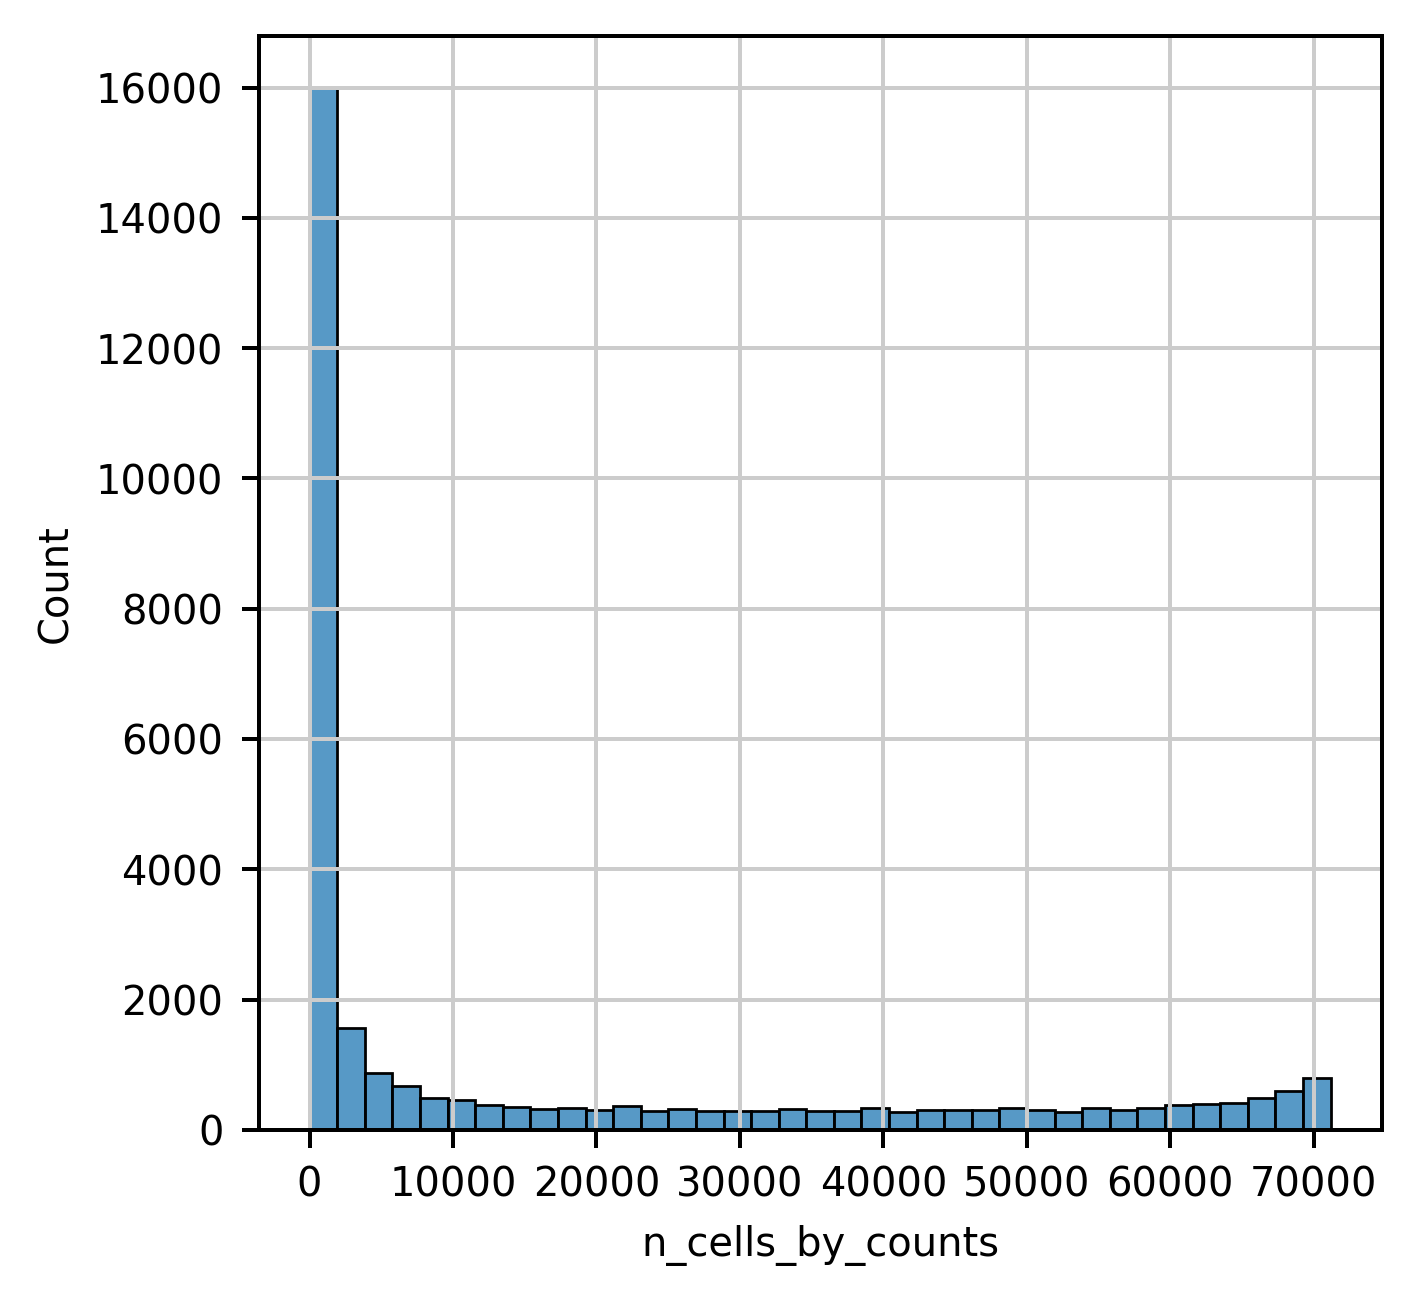

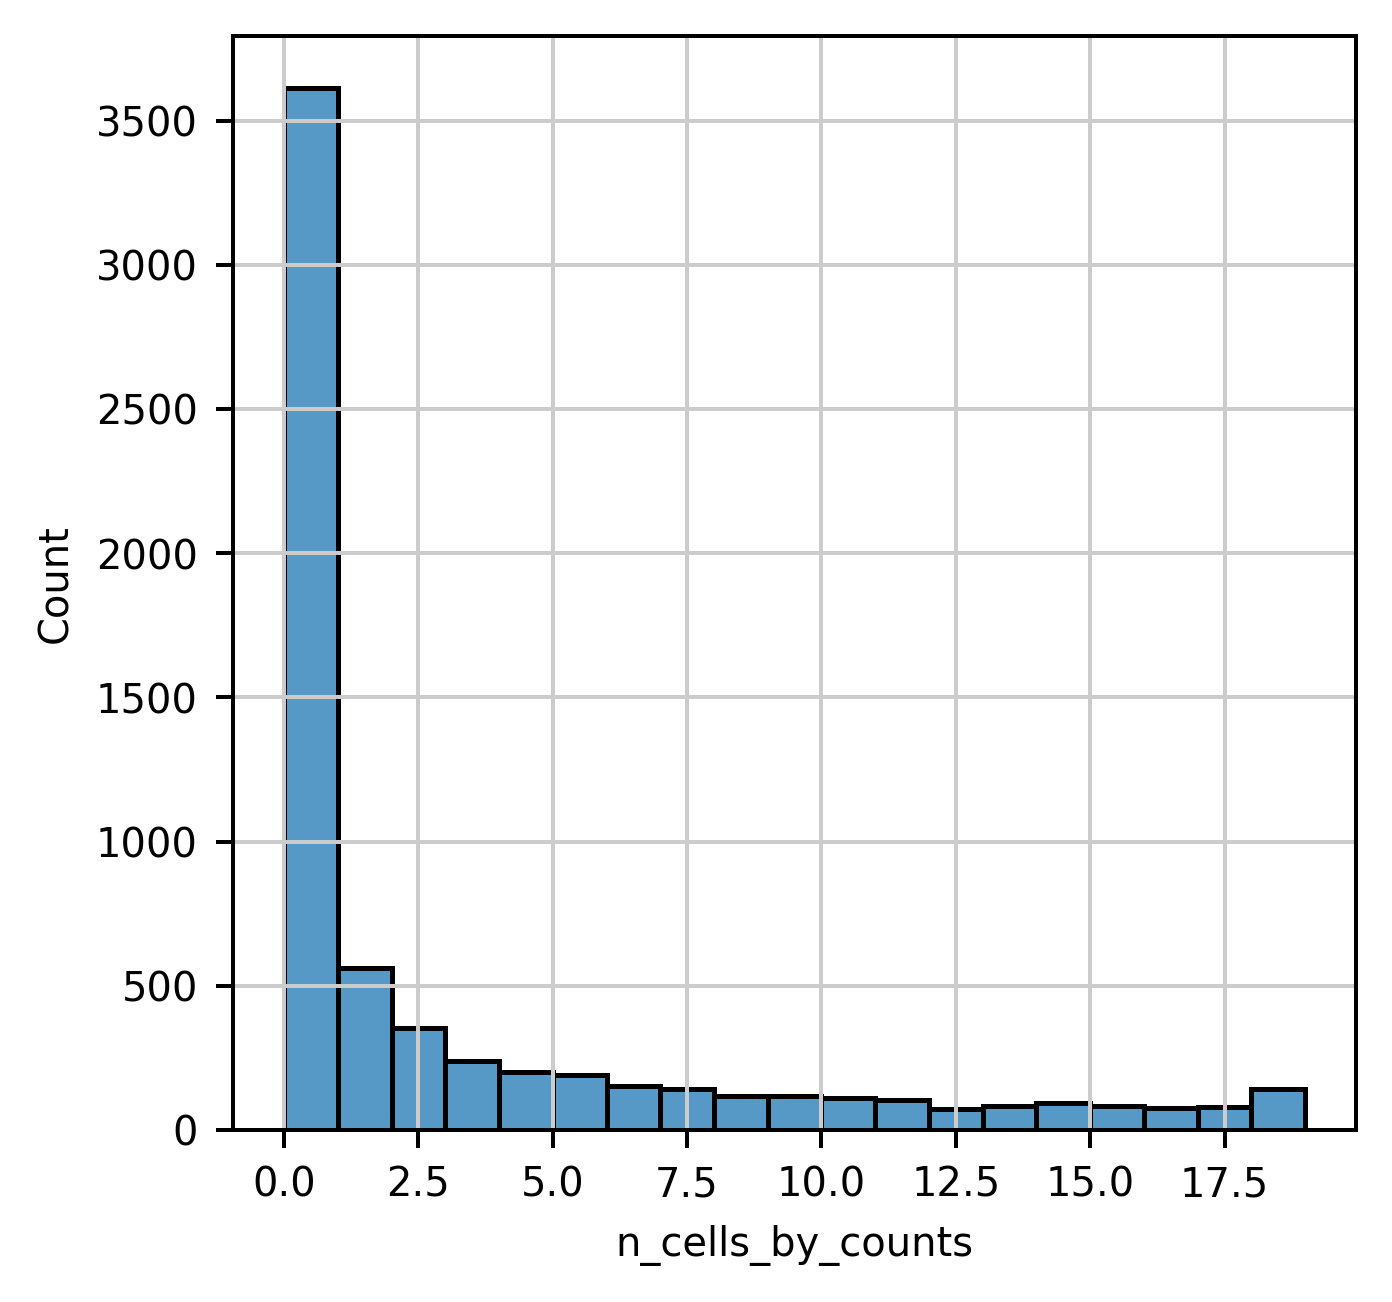

View of AnnData object with n_obs × n_vars = 71183 × 25252
    obs: 'cluster', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'max_mean_cluster_count', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [6]:
# Quality control
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

# Plot the number of cells in which each gene is expressed
sns.histplot(data=adata.var, x='n_cells_by_counts')
plt.show()
sns.histplot(data=adata.var, x='n_cells_by_counts', bins=list(range(20)))
plt.show()

# Filter out genes that are only expressed in few cells
adata = adata[:, adata.var['n_cells_by_counts'] > 10]
adata_raw = adata.copy()
adata

In [7]:
# Preprocess
# Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell
sc.pp.normalize_total(adata, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata)
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

/home/xingjie/.local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


... storing 'cluster_label' as categorical
... storing 'subclass_label' as categorical
... storing 'class_label' as categorical
... storing 'cluster_color' as categorical


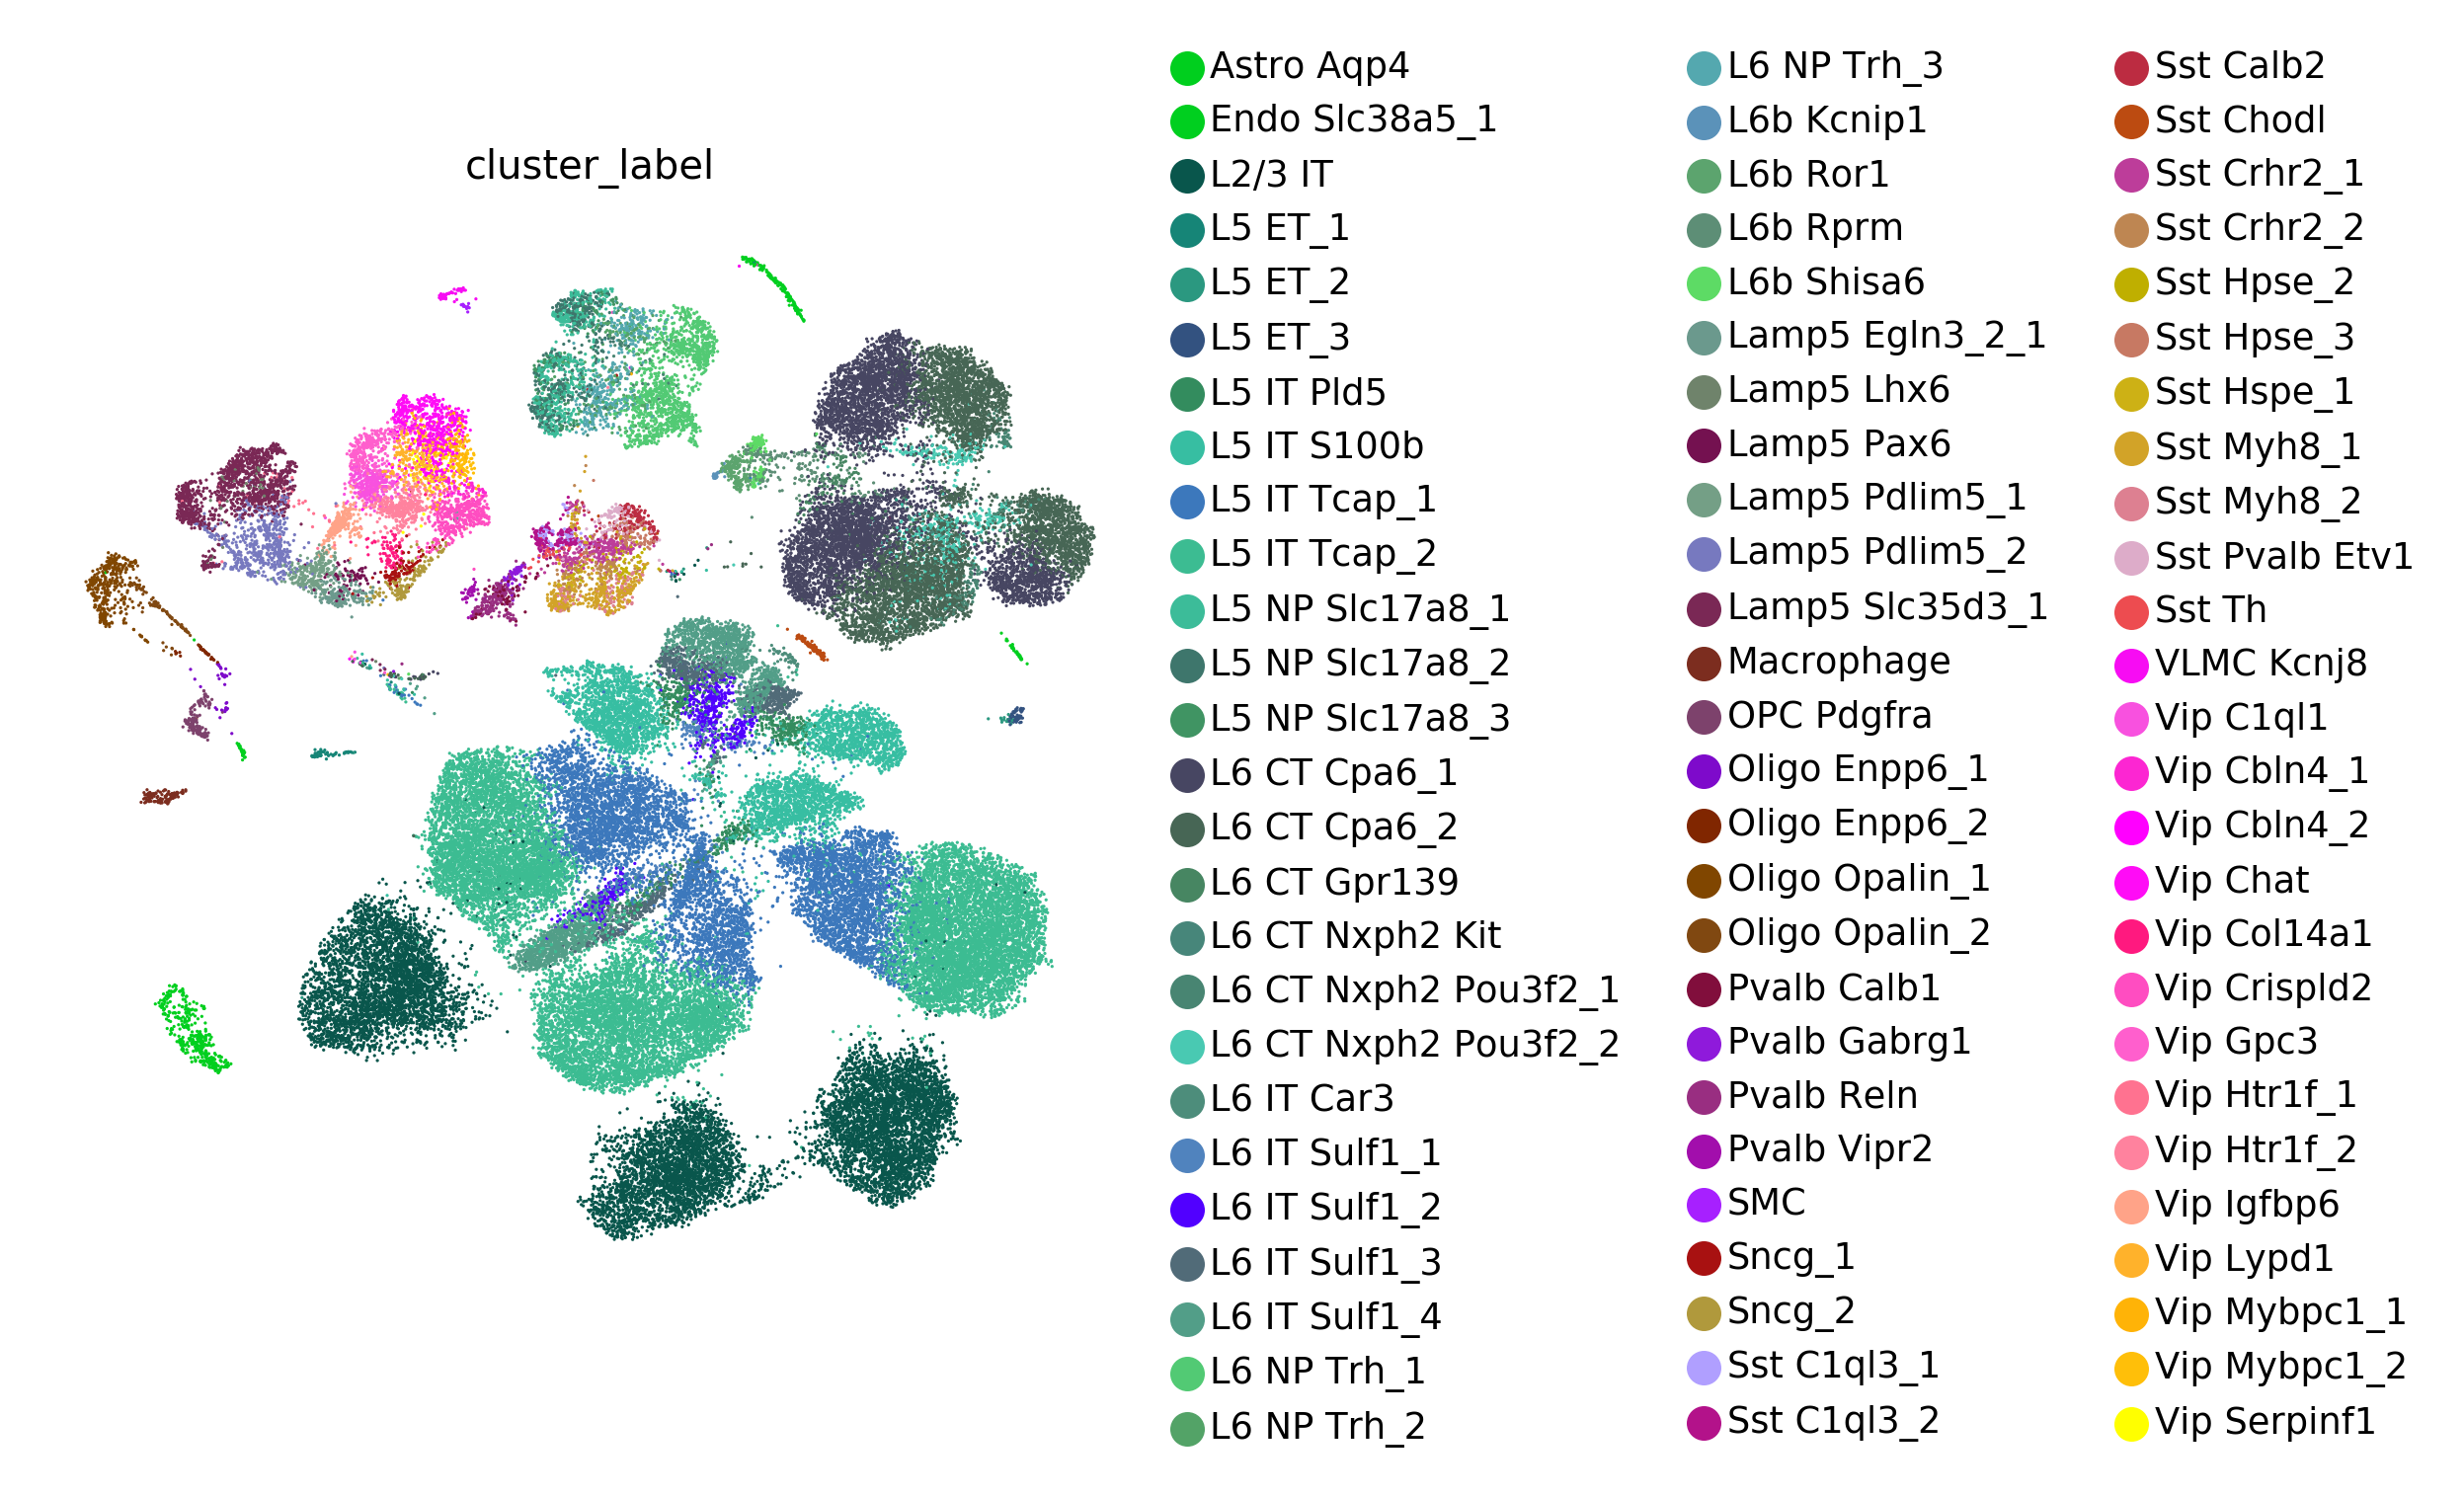

CPU times: user 24min 43s, sys: 9min 53s, total: 34min 36s
Wall time: 1min 38s


In [8]:
%%time
# Plot the clusters onto UMAP
# Principal component analysis
sc.tl.pca(adata, svd_solver='arpack')
# Computing the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
# Embed with UMAP
sc.tl.umap(adata)
# Set the colors for plotting clusters
adata.uns['cluster_label_colors'] = np.unique(adata.obs['cluster_color'])
# Plot the clusters (it seems that there are some batch effect in this dataset)
sc.pl.umap(adata, color='cluster_label')

# Select target genes

In [9]:
# Filter the genes by gene type and expression level
filtered_genes = np.array(adata.var.index)

# Remove the highly expressed genes that may cause over-crowding in MERFISH
percentile_threshold = 99
mask1 = adata.var['mean_counts'] < np.percentile(adata.var['mean_counts'], percentile_threshold)
mask2 = adata.var['max_mean_cluster_count'] < np.percentile(adata.var['max_mean_cluster_count'], percentile_threshold)
mask = mask1 & mask2
filtered_genes = filtered_genes[mask]

# Remove all mitochondrial genes
mask = [not g.lower().startswith('mt-') for g in filtered_genes]
filtered_genes = filtered_genes[mask]

In [10]:
%%time
# Select the marker genes
adata_filtered = adata_raw[:, adata_raw.var.index.isin(filtered_genes)]
# Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell
sc.pp.normalize_total(adata_filtered, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata_filtered)

# Define the marker genes as the differentially expressed genes
sc.tl.rank_genes_groups(adata_filtered, 'cluster_label', method='wilcoxon')

# Select the top marker genes
N_genes_to_select = 200
marker_genes = set()

for i in range(len(adata_filtered.uns['rank_genes_groups']['names'])):
    new_markers = set(adata_filtered.uns['rank_genes_groups']['names'][i])
    
    for m in new_markers:
        marker_genes.add(m)
        if len(marker_genes) >= N_genes_to_select:
            break
            
    if len(marker_genes) >= N_genes_to_select:
            break

marker_genes = np.array(list(marker_genes))
print(f'Found {len(marker_genes)} marker genes.')

/home/xingjie/.local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... storing 'cluster_label' as categorical
... storing 'subclass_label' as categorical
... storing 'class_label' as categorical
... storing 'cluster_color' as categorical


Found 200 marker genes.
CPU times: user 6min 20s, sys: 32 s, total: 6min 52s
Wall time: 6min 52s


In [11]:
selected_genes = marker_genes

# Validate selected genes

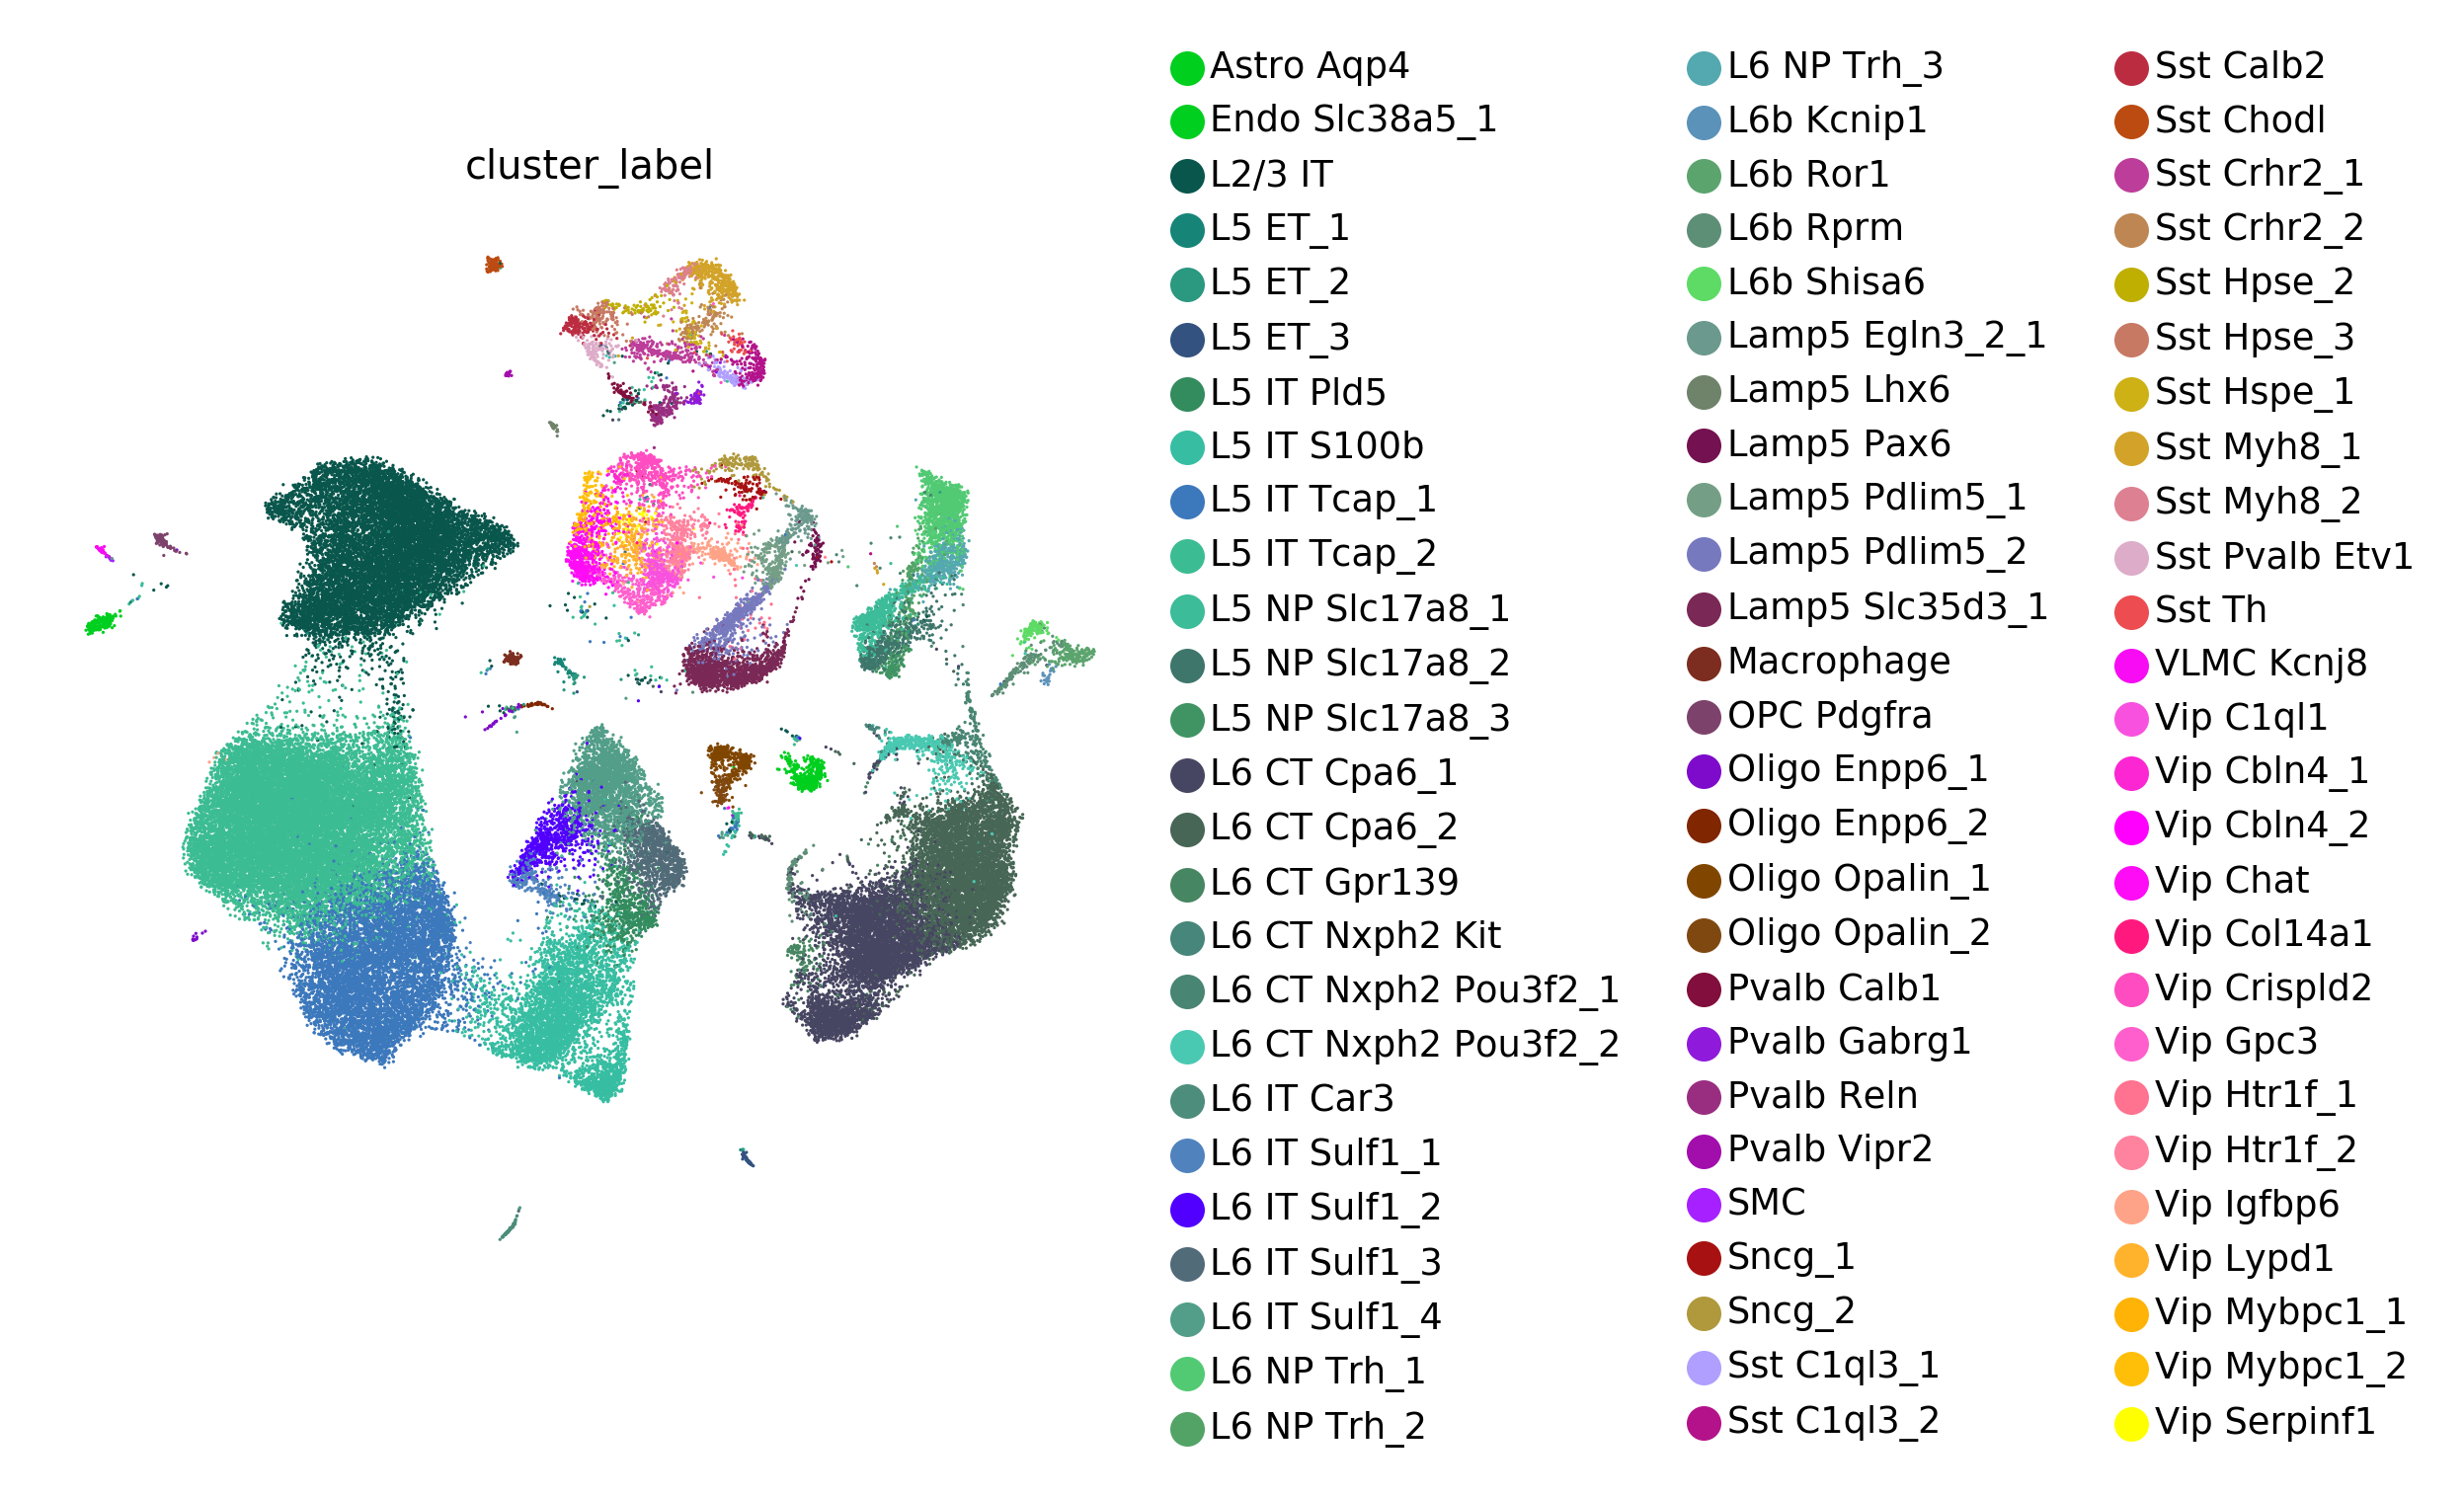

CPU times: user 3min 43s, sys: 2min 38s, total: 6min 22s
Wall time: 42.3 s


In [12]:
%%time
# Validate that the selected genes recapitulate the cluster structures
adata_selected = adata[:, adata.var.index.isin(selected_genes)]
# Principal component analysis
sc.tl.pca(adata_selected, svd_solver='arpack')
# Computing the neighborhood graph
sc.pp.neighbors(adata_selected, n_neighbors=10, n_pcs=40)
# Embed with UMAP
sc.tl.umap(adata_selected)
# Plot the clusters
sc.pl.umap(adata_selected, color='cluster_label')
# Interestingly, the selected genes also removed the batch effect

Train a classifier using 200 genes and 49828 cells.
Predict cell types.


<ipython-input-34-6572f0a0a9d4>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_counts['count'] = 1


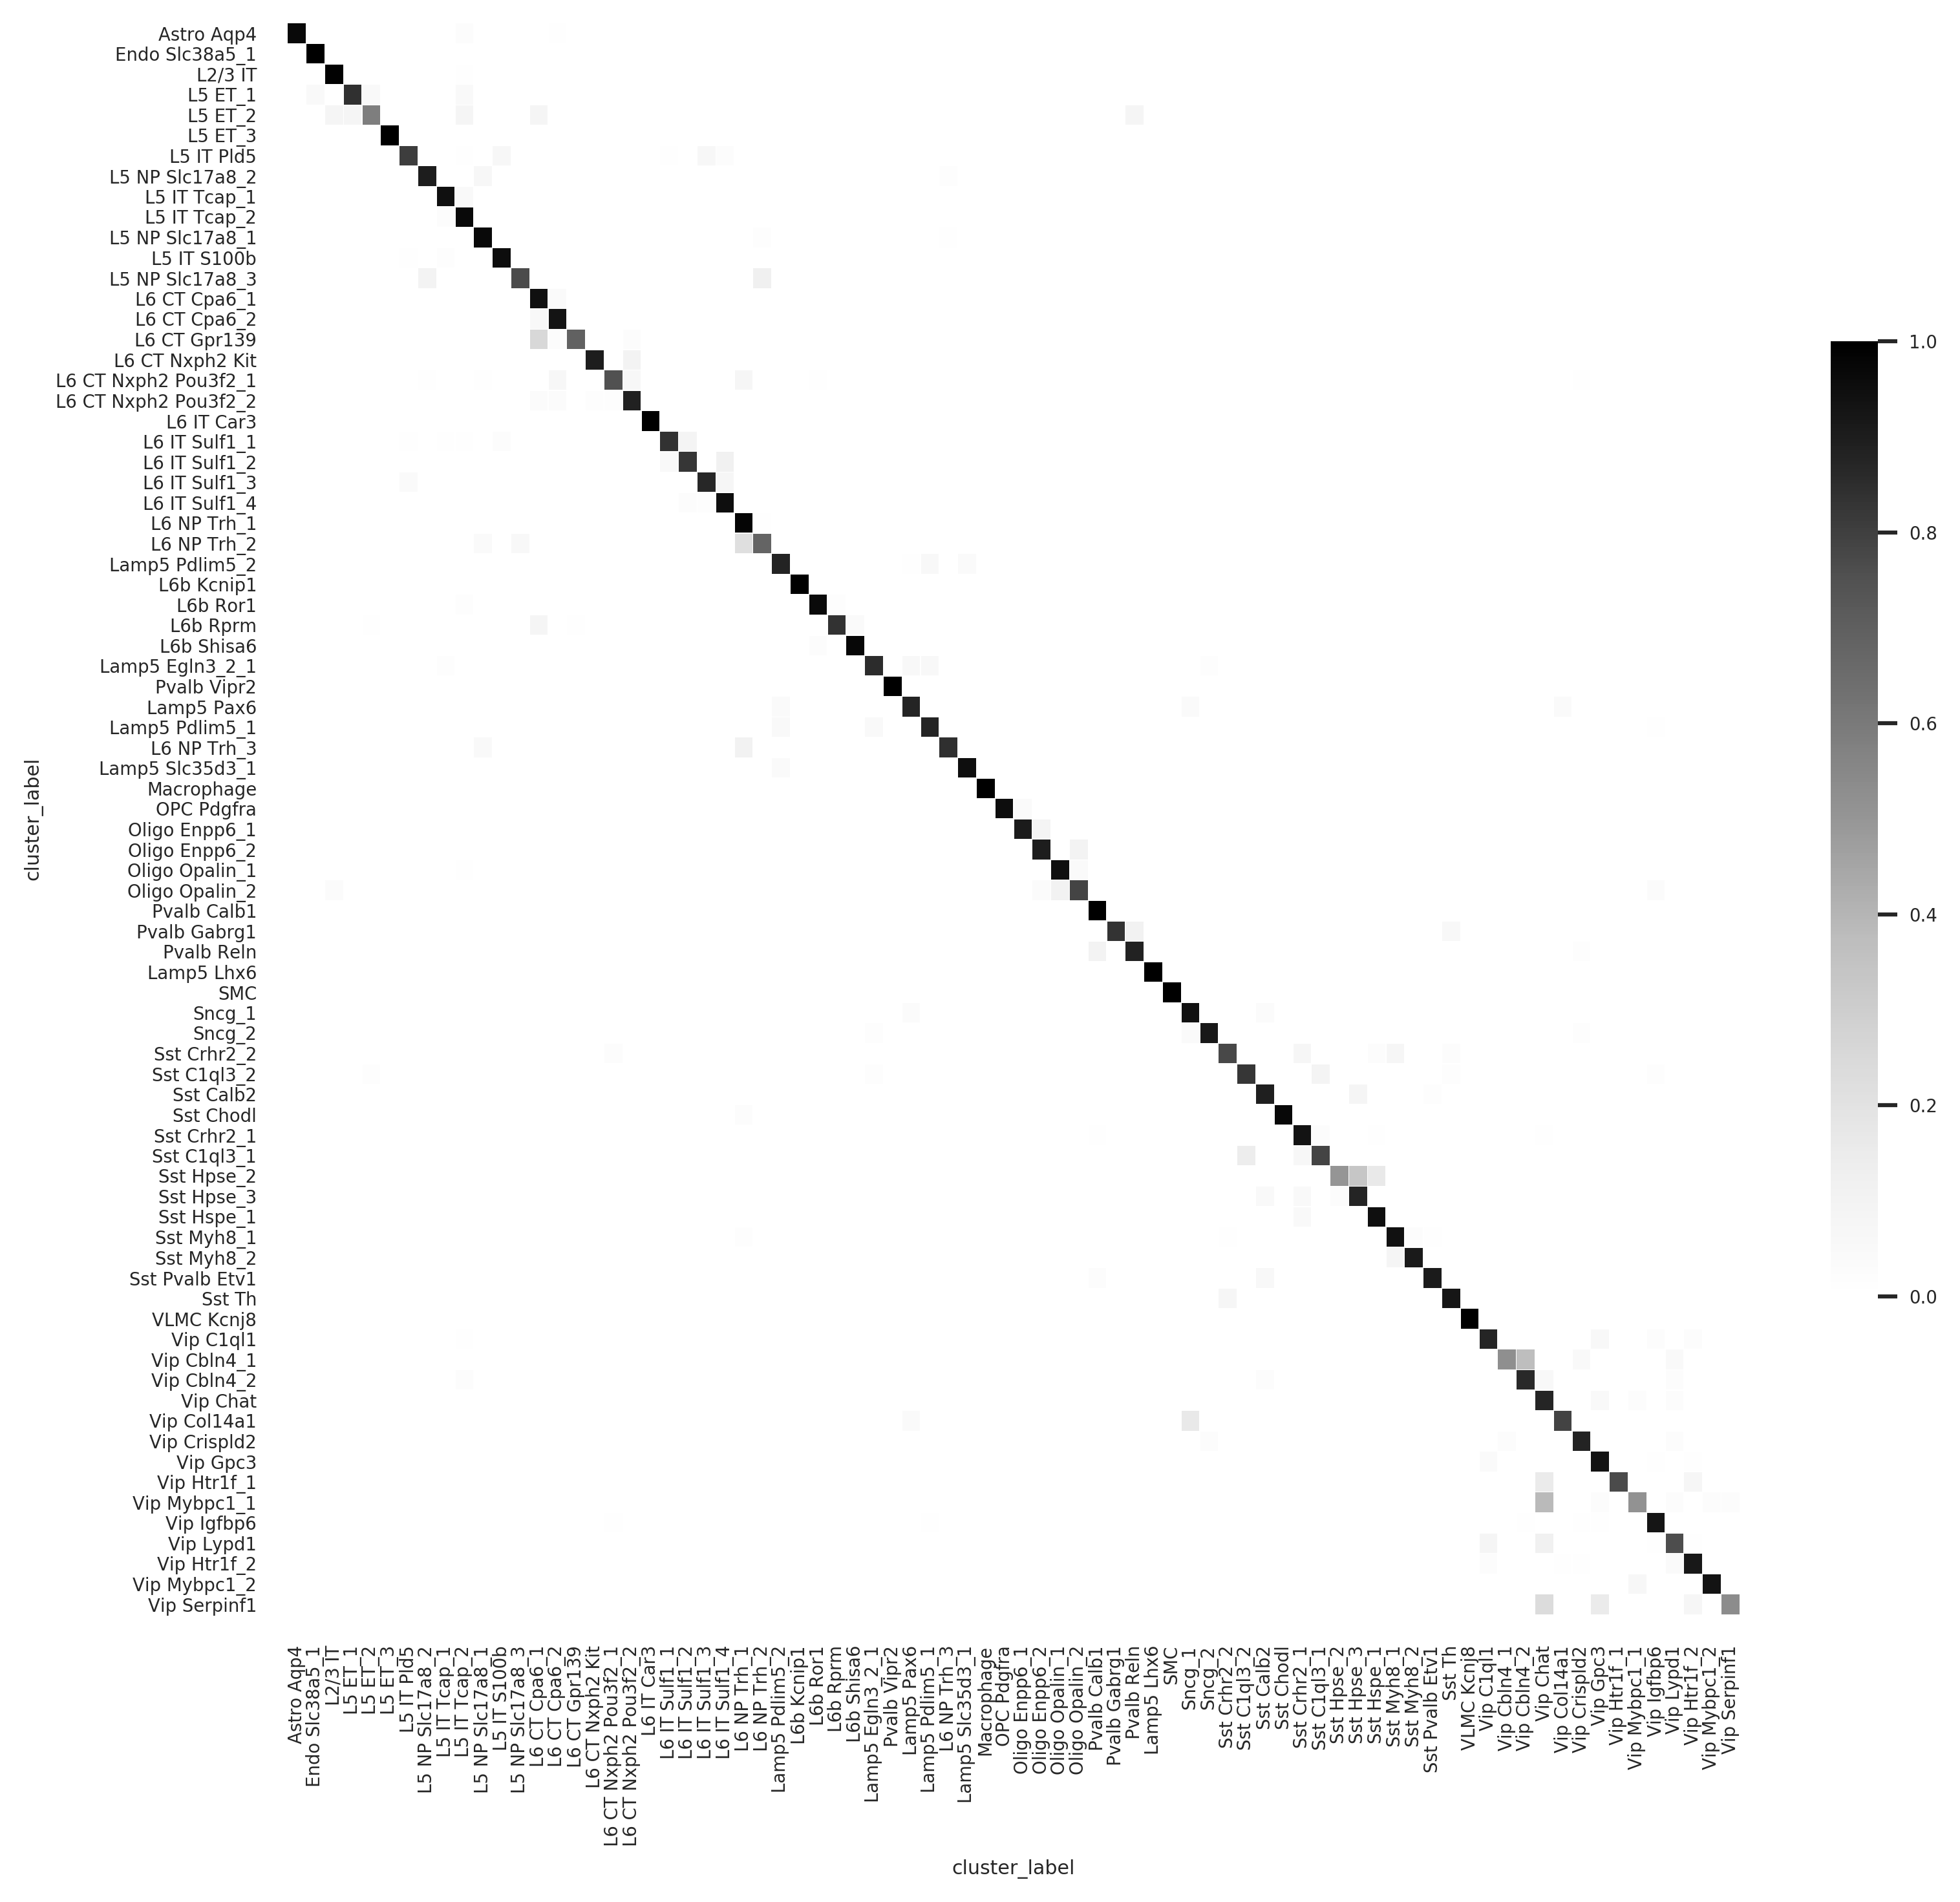

In [37]:
# Validate that the select set of genes is sufficient to distinguish different clusters
train_ids, test_ids = train_test_split(np.arange(adata_selected.obs.shape[0]), 
                                       stratify=list(adata_selected.obs['cluster_label']), test_size=0.3)
adata_train = adata_selected[train_ids]
adata_test = adata_selected[test_ids]
fractions_sorted = plot_cluster_correspondance(adata_train, adata_test, 'cluster_label', 'cluster_label',
                            prediction_column='predicted_classes', font_scale=0.5)

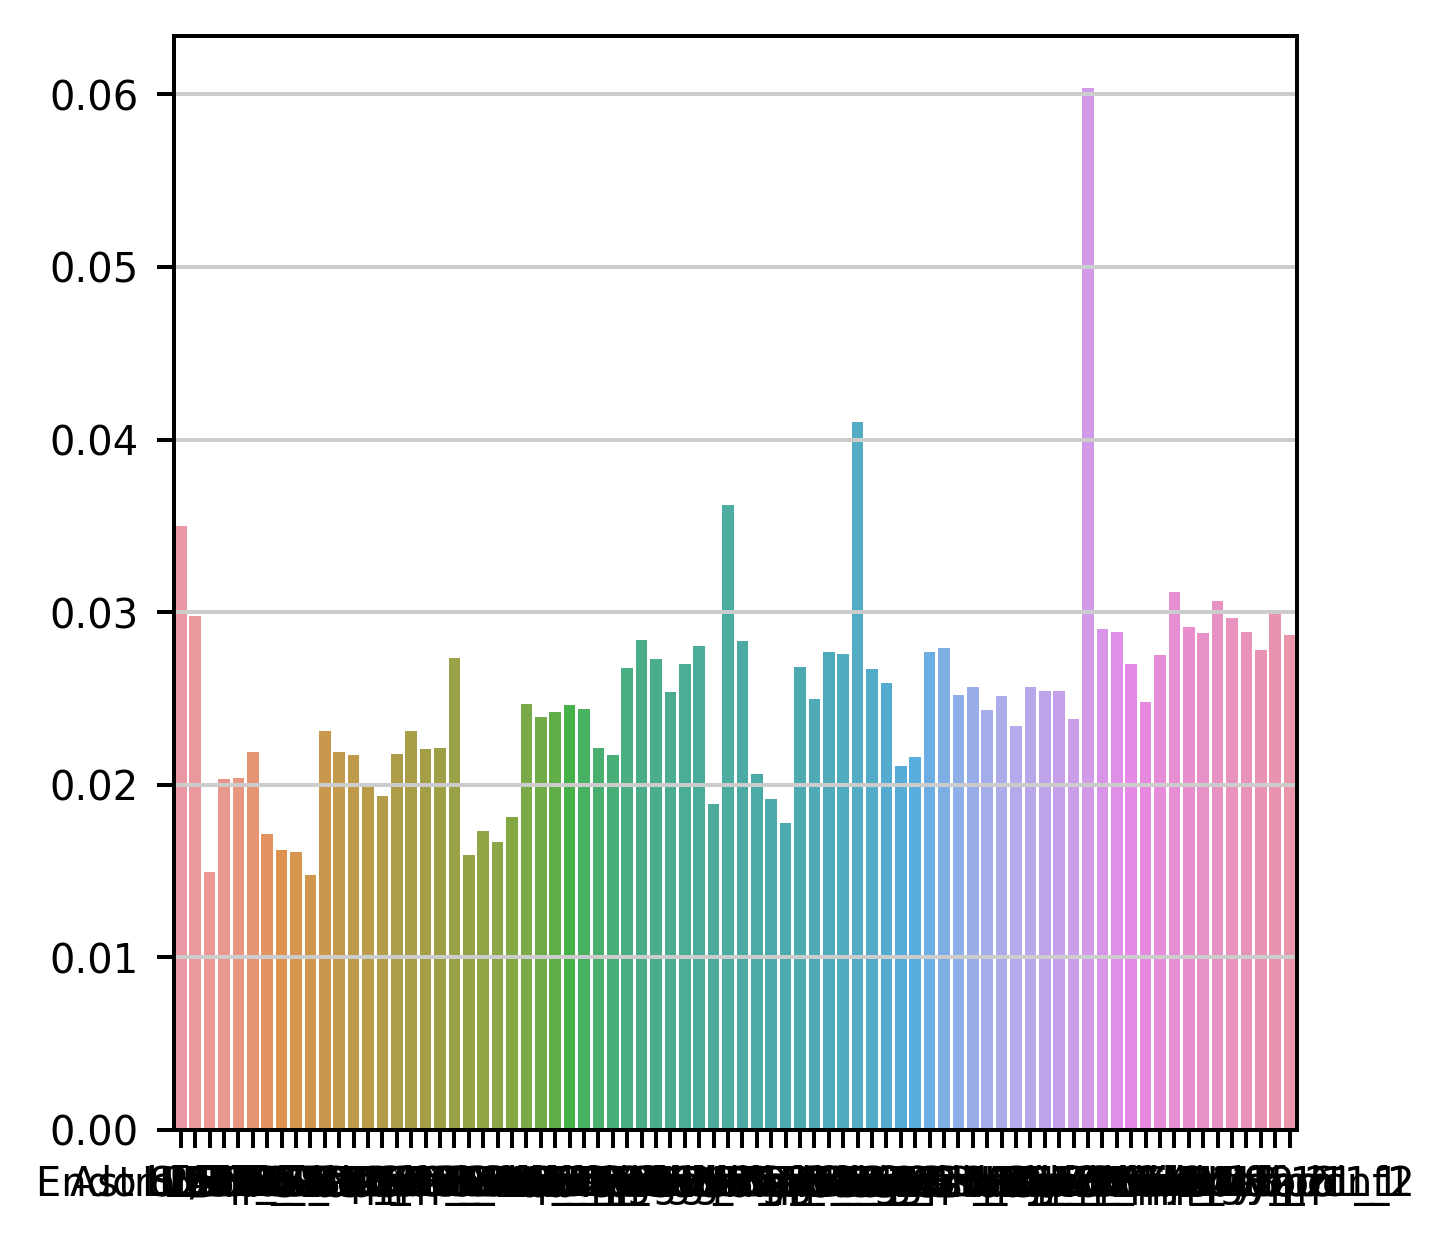

[('VLMC Kcnj8', 0.060382497),
 ('SMC', 0.041008264),
 ('OPC Pdgfra', 0.036205534),
 ('Astro Aqp4', 0.03497516),
 ('Vip Crispld2', 0.031142099),
 ('Vip Htr1f_2', 0.030664181),
 ('Vip Mybpc1_2', 0.029928645),
 ('Endo Slc38a5_1', 0.029766394),
 ('Vip Igfbp6', 0.029675517),
 ('Vip Gpc3', 0.029164918),
 ('Vip C1ql1', 0.02903713),
 ('Vip Lypd1', 0.028846463),
 ('Vip Cbln4_1', 0.028825937),
 ('Vip Htr1f_1', 0.028785888),
 ('Vip Serpinf1', 0.028677879),
 ('Lamp5 Lhx6', 0.028358737),
 ('Oligo Enpp6_1', 0.028345382),
 ('Lamp5 Slc35d3_1', 0.028021561),
 ('Sst Chodl', 0.02795227),
 ('Vip Mybpc1_1', 0.027791308),
 ('Pvalb Reln', 0.027718758),
 ('Sst Calb2', 0.02768633),
 ('Pvalb Vipr2', 0.027572915),
 ('Vip Col14a1', 0.027525714),
 ('L6 IT Car3', 0.027340569),
 ('Lamp5 Pax6', 0.027303865),
 ('Lamp5 Pdlim5_2', 0.02700042),
 ('Vip Cbln4_2', 0.026990226),
 ('Pvalb Calb1', 0.02681373),
 ('Lamp5 Egln3_2_1', 0.02678331),
 ('Sncg_1', 0.026689762),
 ('Sncg_2', 0.025922008),
 ('Sst Myh8_1', 0.025690272),
 (

In [13]:
# Make sure the expression level of selected genes are not too high. 
# Plot the fraction of counts of selected genes in each cluster.
# Emperically, the detection efficiency is very good if the fraction is below 0.03.
cluster_labels = np.unique(adata_raw.obs['cluster_label'])
cluster_exp_fraction = []

for cl in cluster_labels:
    X_cluster = adata_raw.X[adata_raw.obs['cluster_label'] == cl]
    total_gene_count = np.sum(X_cluster)
    selected_gene_count = np.sum(X_cluster[:, adata_raw.var.index.isin(selected_genes)])

    cluster_exp_fraction.append(selected_gene_count / total_gene_count)
    
sns.barplot(x=cluster_labels, y=cluster_exp_fraction)
plt.show()

cell_type_and_expression = list(zip(cluster_labels, cluster_exp_fraction))
sorted(cell_type_and_expression, reverse=True, key=lambda x:x[1])

# Save the result

In [14]:
# Save the selected genes
df = adata.var[adata.var.index.isin(selected_genes)][['gene_ids']]
df.to_csv(selected_genes_file)